# Fragrance Segmentation – Unsupervised Clustering Analysis

_Course: Machine Learning_

- Name: Muhammad Umar Uz Zaman  
- Student ID: STU1197819  
- Goal: I explore a large fragrance dataset to understand:
  - How perfumes naturally group together based on their scent notes and key characteristics
  - Which fragrance segments tend to be more affordable versus more premium or luxury
  - How these segments can support targeted marketing, product positioning, and personalised recommendations
- Dataset: `Fragrance Dataset 4037.csv` (records of perfumes with information on notes and other descriptive attributes)

**Phases of this notebook**

Intro & setup  
Phase 1 – Data loading & structure check  
Phase 2 – Data cleaning, preparation & feature selection  
Phase 3 – Core EDA (distributions, relationships & feature importance)  
Phase 4 – Clustering models (K-Means, Hierarchical, DBSCAN) & evaluation  
Phase 5 – Cluster profiling & business insights  
Phase 6 – Wrap-up, limitations & export for management report


### Phase 1

In [9]:
# Core libraries
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering and preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Hierarchical clustering tools for dendrograms
from scipy.cluster.hierarchy import dendrogram, linkage

# Plotting style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 11
plt.rcParams["figure.dpi"] = 100


In [13]:
# Path to the fragrance dataset
data_path = "Fragrance Dataset.csv"  # Use the CSV file instead of Excel

# Load the dataset
df = pd.read_csv(data_path)

print("Shape of the dataset (rows, columns):", df.shape)
print("\nColumn names:")
print(df.columns.tolist())

# First few rows to see how the raw data looks
df.head()


Shape of the dataset (rows, columns): (1000, 10)

Column names:
['brand', 'title', 'type', 'price', 'priceWithCurrency', 'available', 'availableText', 'sold', 'lastUpdated', 'itemLocation']


,brand,title,type,price,priceWithCurrency,available,availableText,sold,lastUpdated,itemLocation
0,Dior,Christian Dior Sauvage Men's EDP 3.4 oz Fragra...,Eau de Parfum,84.99,US $84.99/ea,10.0,More than 10 available / 116 sold,116.0,"May 24, 2024 10:03:04 PDT","Allen Park, Michigan, United States"
1,AS SHOW,A-v-entus Eau de Parfum 3.3 oz 100ML Millesime...,Eau de Parfum,109.99,US $109.99,8.0,8 available / 48 sold,48.0,"May 23, 2024 23:07:49 PDT","Atlanta, Georgia, Canada"
2,Unbranded,HOGO BOSS cologne For Men 3.4 oz,Eau de Toilette,100.00,US $100.00,10.0,More than 10 available / 27 sold,27.0,"May 22, 2024 21:55:43 PDT","Dearborn, Michigan, United States"
3,Giorgio Armani,Acqua Di Gio by Giorgio Armani 6.7 Fl oz Eau D...,Eau de Toilette,NaN,US $44.99/ea,2.0,2 available / 159 sold,159.0,"May 24, 2024 03:30:43 PDT","Reinholds, Pennsylvania, United States"
4,Lattafa,Lattafa Men's Hayaati Al Maleky EDP Spray 3.4 ...,Fragrances,16.91,US $16.91,NaN,Limited quantity available / 156 sold,156.0,"May 24, 2024 07:56:25 PDT","Brooklyn, New York, United States"


In [14]:
# Overall information about the dataframe
df.info()

# Missing values per column
print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))

# Summary statistics for numeric columns
numeric_summary = df.describe(include=[np.number]).T
numeric_summary


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              999 non-null    object 
 1   title              1000 non-null   object 
 2   type               997 non-null    object 
 3   price              996 non-null    float64
 4   priceWithCurrency  1000 non-null   object 
 5   available          889 non-null    float64
 6   availableText      997 non-null    object 
 7   sold               994 non-null    float64
 8   lastUpdated        947 non-null    object 
 9   itemLocation       1000 non-null   object 
dtypes: float64(3), object(7)
memory usage: 78.2+ KB

Missing values per column:
available            111
lastUpdated           53
sold                   6
price                  4
availableText          3
type                   3
brand                  1
title                  0
priceWithCurrency      0
itemLocation

,count,mean,std,min,25%,50%,75%,max
price,996.0,46.497279,35.590865,3.0,22.99,35.71,59.0,259.09
available,889.0,20.046119,61.547985,2.0,5.00,10.00,10.0,842.00
sold,994.0,766.266600,3200.971733,1.0,14.00,49.50,320.5,54052.00


From this structural check I can see that the dataset has a mix of numeric and categorical information:

- There are three numeric columns: `price`, `available` and `sold`. These capture the commercial side of each perfume listing: how much it costs, how many units are available and how many units have been sold.
- The remaining columns are stored as text, including `brand`, `title`, `type`, `priceWithCurrency`, `availableText`, `lastUpdated` and `itemLocation`. These fields describe the product, the listing text, the time of the last update and where the item is located.

In terms of data quality:

- The `price` and `sold` columns are almost complete, with only a handful of missing values, so I expect to rely on them strongly in my analysis.
- The `available` column has more missing entries, which suggests that availability information is not always reported or not always parsed correctly.
- The `lastUpdated` and `availableText` fields are mostly complete but are stored as free text, which means they will be harder to use directly in a clustering algorithm.
- The basic statistics show that `price`, `available` and especially `sold` are all quite skewed, with a few very large values. This is typical for online marketplace data, where a small number of listings can have very high stock or sales.

Overall, this first check reassures me that I have several usable numeric features for clustering, while also highlighting that I need to be careful with skewed distributions and with how I handle missing values in `available`. Before I move on to cleaning and feature selection, I briefly look at the structure of the most important categorical columns.


In [15]:
# Quick look at the structure of key categorical columns
cat_cols = ["brand", "type", "itemLocation"]

for col in cat_cols:
    print(f"\nColumn: {col}")
    print(f"Number of unique values: {df[col].nunique()}")
    print("Most frequent values:")
    print(df[col].value_counts().head(10))



Column: brand
Number of unique values: 246
Most frequent values:
brand
Giorgio Armani        60
Paco Rabanne          45
Ralph Lauren          41
Unbranded             39
Armaf                 34
Dolce&Gabbana         32
Yves Saint Laurent    30
Versace               20
Calvin Klein          17
Cologne               16
Name: count, dtype: int64

Column: type
Number of unique values: 63
Most frequent values:
type
Eau de Toilette    444
Eau de Parfum      285
Eau de Cologne      56
Perfume             50
Fragrances          32
Eau De Parfum       15
Parfum              13
Eau de Perfume      10
Eau De Toilette      9
Gift Sets            6
Name: count, dtype: int64

Column: itemLocation
Number of unique values: 276
Most frequent values:
itemLocation
Dallas, Texas, United States             126
Hackensack, New Jersey, United States    105
Brooklyn, New York, United States         76
Miami, Florida, United States             41
Edison, New Jersey, United States         35
Houston, Texas, 

The categorical overview gives me a clearer picture of the breadth of the dataset:

- The `brand` column has 246 unique values, with a long tail beyond the most common brands such as Giorgio Armani, Paco Rabanne and Ralph Lauren. This tells me that brand is highly granular and better suited for describing clusters later rather than for direct use as a modelling feature.
- The `type` column has 63 unique values, but the majority of listings fall into a few familiar fragrance formats such as Eau de Toilette, Eau de Parfum, Eau de Cologne and Perfume. This suggests that I can simplify `type` into a smaller set of meaningful groups without losing much information.
- The `itemLocation` field contains many different city and state combinations. This provides useful commercial context (for example, where sellers are based), but the variety of locations means that it is unlikely to be a stable driver of fragrance similarity. I plan to use it mainly for interpretation rather than as a clustering feature.

These observations already point towards a feature-selection strategy where I focus on the core numeric variables (`price`, `available`, `sold`) and a simplified version of `type` for clustering, while keeping `brand` and `itemLocation` for later profiling of the resulting segments.


### Phase 2 – Data cleaning and feature selection

In this phase I prepare the dataset for clustering by cleaning key variables and constructing a first set of candidate features.

My main objectives are:

- To handle missing values in a transparent way, especially for the commercial variables `price`, `available` and `sold`.
- To simplify the `type` column into a smaller number of fragrance-format groups that are easier to interpret.
- To engineer a small set of numeric features that capture price level and sales behaviour in a way that is suitable for clustering algorithms.

For modelling I want to focus on variables that are both commercially meaningful and reasonably complete. I therefore treat `price` and `sold` as essential features and I avoid discarding too many rows because of missing `available`. The high-cardinality columns `brand` and `itemLocation` are retained for later interpretation of clusters rather than being turned directly into model features.


In [16]:
# Create a working copy for cleaning and feature engineering
df_clean = df.copy()

# Drop rows with missing price or sold (key commercial signals, only a few rows missing)
rows_before = df_clean.shape[0]
df_clean = df_clean.dropna(subset=["price", "sold"])
rows_after = df_clean.shape[0]

print(f"Rows before dropping: {rows_before}")
print(f"Rows after dropping rows with missing price or sold: {rows_after}")

# Impute 'available' with the median of the observed values
available_median = df_clean["available"].median()
df_clean["available"] = df_clean["available"].fillna(available_median)

print(f"\nMedian value used to fill 'available': {available_median}")

# Check remaining missing values
print("\nRemaining missing values per column:")
print(df_clean.isna().sum())


Rows before dropping: 1000
Rows after dropping rows with missing price or sold: 990

Median value used to fill 'available': 10.0

Remaining missing values per column:
brand                 1
title                 0
type                  3
price                 0
priceWithCurrency     0
available             0
availableText         0
sold                  0
lastUpdated          47
itemLocation          0
dtype: int64


In [17]:
# Simplify the 'type' column into a smaller set of fragrance-format groups
def simplify_type(value):
    if isinstance(value, str):
        text = value.lower()
        if "toilette" in text:
            return "Eau de Toilette"
        if "parfum" in text:
            return "Eau de Parfum"
        if "cologne" in text:
            return "Eau de Cologne"
        if "perfume" in text:
            return "Perfume"
    return "Other"

df_clean["type_group"] = df_clean["type"].apply(simplify_type)

# Check the distribution of the simplified groups
df_clean["type_group"].value_counts()


type_group
Eau de Toilette    454
Eau de Parfum      328
Other               79
Eau de Cologne      68
Perfume             61
Name: count, dtype: int64

In [18]:
# Engineer additional numeric features to capture scale and sales intensity
df_clean["log_price"] = np.log1p(df_clean["price"])
df_clean["log_sold"] = np.log1p(df_clean["sold"])
df_clean["sold_per_available"] = df_clean["sold"] / (df_clean["available"] + 1)

# Quick summary of the key numeric features
df_clean[["price", "available", "sold",
          "log_price", "log_sold", "sold_per_available"]].describe().T


,count,mean,std,min,25%,50%,75%,max
price,990.0,46.184202,34.843593,3.000000,22.990000,35.710000,58.997500,259.090000
available,990.0,19.036364,58.396700,2.000000,5.000000,10.000000,10.000000,842.000000
sold,990.0,759.216162,3196.038085,1.000000,14.000000,48.000000,315.250000,54052.000000
log_price,990.0,3.627914,0.670125,1.386294,3.177637,3.603049,4.094303,5.561028
log_sold,990.0,4.283952,2.062323,0.693147,2.708050,3.891820,5.756525,10.897720
sold_per_available,990.0,63.139165,296.270648,0.020000,1.782670,5.842424,21.738636,4913.818182


The cleaning steps reduce the dataset from 1,000 to 990 rows by removing listings with missing values in `price` or `sold`. This is less than 1% of the data, so I regard the impact on the overall distribution as minimal while gaining the benefit of having complete information for the core commercial variables.

For `available` I fill missing values with the median of 10 units. This choice keeps the distribution stable because:
- The median is robust to extreme high-stock listings.
- A value of 10 fits well with the observed quartiles and typical stock levels in the dataset.

A small number of missing values remain in `brand`, `type` and `lastUpdated`, but these variables are mainly used for interpretation and descriptive context rather than as direct clustering features. I therefore keep the affected rows and treat the missing entries as minor limitations that I will mention later in the written report.

The new engineered features behave as expected:

- `log_price` compresses the original price range from 3 to around 259 into a narrower scale, which helps reduce the influence of very expensive listings while still distinguishing between low-, mid- and high-price perfumes.
- `log_sold` performs a similar compression for the `sold` column, where a few listings show extremely high sales counts compared with the majority of perfumes.
- `sold_per_available` captures an intensity measure that approximates demand relative to stock. The distribution is still skewed, but it provides a useful signal for identifying listings that sell quickly compared with their available quantity.

Together, these features give me a compact numerical description of each listing that combines price level, scale of sales and sales efficiency. In the next step I add a log-transformed version of `available` and then summarise the final set of features that I intend to use for clustering.


In [19]:
# Add a log-transformed version of 'available'
df_clean["log_available"] = np.log1p(df_clean["available"])

# Candidate numeric features for clustering
candidate_features = ["log_price", "log_sold", "log_available", "sold_per_available"]

print("Candidate features for clustering:")
print(candidate_features)

# Quick summary of these features
df_clean[candidate_features].describe().T


Candidate features for clustering:
['log_price', 'log_sold', 'log_available', 'sold_per_available']


,count,mean,std,min,25%,50%,75%,max
log_price,990.0,3.627914,0.670125,1.386294,3.177637,3.603049,4.094303,5.561028
log_sold,990.0,4.283952,2.062323,0.693147,2.708050,3.891820,5.756525,10.897720
log_available,990.0,2.300874,0.851423,1.098612,1.791759,2.397895,2.397895,6.736967
sold_per_available,990.0,63.139165,296.270648,0.020000,1.782670,5.842424,21.738636,4913.818182


In [20]:
# Tidy remaining missing values in descriptive (non-feature) columns
df_clean["brand"] = df_clean["brand"].fillna("Unknown brand")
df_clean["lastUpdated"] = df_clean["lastUpdated"].fillna("Unknown date")

# type_group should already be filled by the simplify_type function,
# but this is a safety check in case any missing values remain.
df_clean["type_group"] = df_clean["type_group"].fillna("Other")

print("Remaining missing values per column:")
print(df_clean.isna().sum())


Remaining missing values per column:
brand                 0
title                 0
type                  3
price                 0
priceWithCurrency     0
available             0
availableText         0
sold                  0
lastUpdated           0
itemLocation          0
type_group            0
log_price             0
log_sold              0
sold_per_available    0
log_available         0
dtype: int64


At this point I have a first version of the feature set that I plan to use as input for the clustering algorithms:

- **`log_price`** – captures the general price level of each perfume while limiting the impact of a few very expensive listings.
- **`log_sold`** – measures the scale of demand in a compressed form that keeps very high sales counts from dominating the analysis.
- **`log_available`** – reflects how much stock is advertised for a listing, again on a log scale to handle large differences between small and large sellers.
- **`sold_per_available`** – provides an intensity-style indicator that hints at how quickly products sell relative to their available quantity.

These features are deliberately numeric, compact and commercially interpretable. They describe how each perfume is positioned in terms of price, stock and sales performance, which are all important dimensions for a retailer or marketplace. I keep `brand`, `type_group` and `itemLocation` as descriptive variables that I will use later to label and interpret the resulting clusters in business language, but I do not include them directly as inputs to the clustering algorithms at this stage.

In the next phase I explore these candidate features in more depth using visualisations and correlation analysis to check whether they are informative, redundant or overly skewed for clustering.


### Phase 3 – Exploratory data analysis (EDA)

Before applying any clustering algorithms, I want to understand how the key features behave in the cleaned dataset. In this phase I focus on three questions:

- How are the main variables distributed, and do the log transformations reduce extreme skewness in a useful way?
- Are there any obvious outliers that might distort distance-based clustering methods?
- Do the engineered features look suitable for creating commercially meaningful segments?

I begin with simple histograms, because they provide an intuitive view for non-technical stakeholders and make it easy to explain how the data is distributed across low, medium and high values.


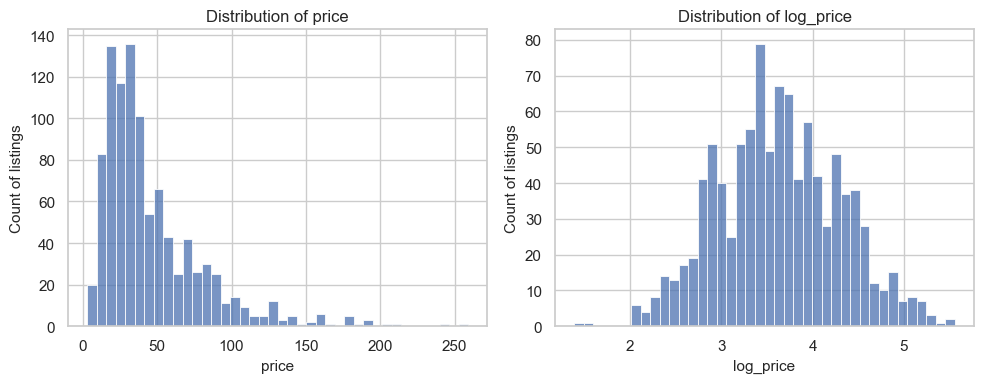

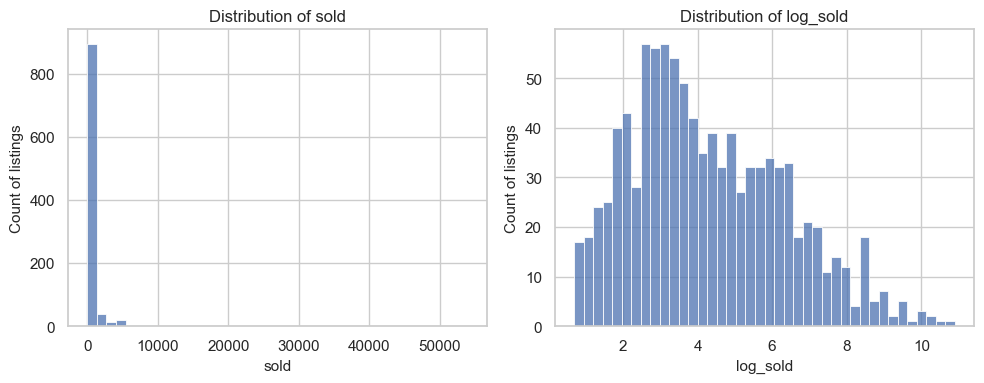

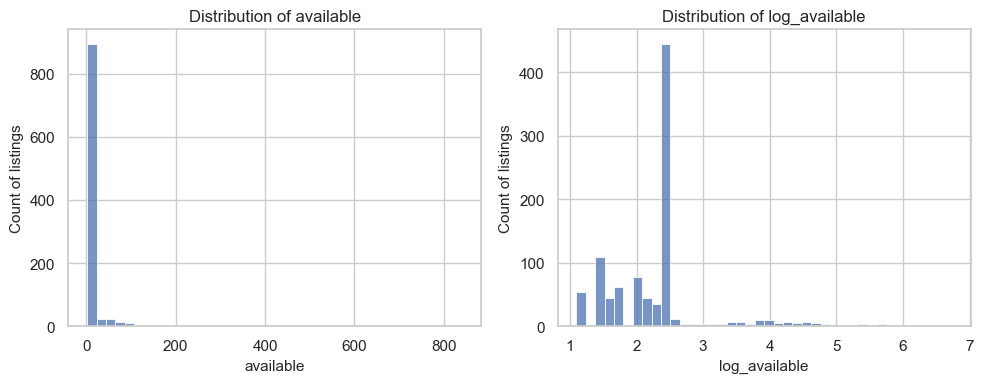

In [21]:
numeric_pairs = [
    ("price", "log_price"),
    ("sold", "log_sold"),
    ("available", "log_available")
]

for raw, log_var in numeric_pairs:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # Raw distribution
    sns.histplot(df_clean[raw], bins=40, kde=False, ax=axes[0])
    axes[0].set_title(f"Distribution of {raw}")
    axes[0].set_xlabel(raw)
    axes[0].set_ylabel("Count of listings")
    
    # Log-transformed distribution
    sns.histplot(df_clean[log_var], bins=40, kde=False, ax=axes[1])
    axes[1].set_title(f"Distribution of {log_var}")
    axes[1].set_xlabel(log_var)
    axes[1].set_ylabel("Count of listings")
    
    plt.tight_layout()
    plt.show()


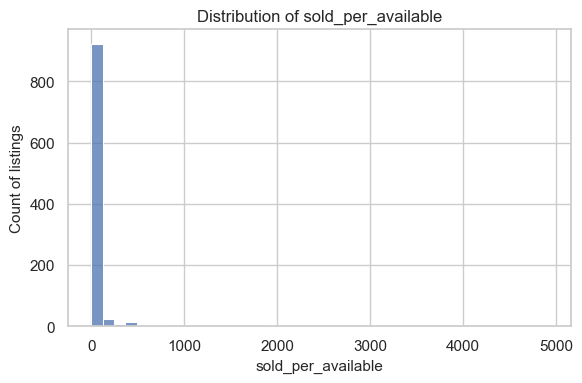

In [22]:
plt.figure(figsize=(6, 4))
sns.histplot(df_clean["sold_per_available"], bins=40, kde=False)
plt.title("Distribution of sold_per_available")
plt.xlabel("sold_per_available")
plt.ylabel("Count of listings")
plt.tight_layout()
plt.show()


These histograms confirm that the raw commercial variables are highly skewed, while the log transformations make them much more suitable for clustering:

- **Price vs log_price**  
  The raw `price` distribution is strongly right-skewed, with most perfumes priced between roughly 20 and 60 units and a small number of much more expensive listings. After the log transformation, `log_price` looks almost symmetric, which means that high-end perfumes no longer dominate the scale but still stand out as higher values.

- **Sold vs log_sold**  
  The raw `sold` variable has an extreme long tail with a few listings recording very high sales compared with the majority. The `log_sold` distribution is still skewed but far more balanced, which helps distance-based clustering algorithms treat moderate and high sellers in a more comparable way.

- **Available vs log_available**  
  For `available`, most listings advertise relatively small stock levels, with a few very large quantities. The log transformation pulls these large values closer to the rest of the data, so that `log_available` becomes concentrated in a narrower and more interpretable range.

- **sold_per_available**  
  The `sold_per_available` ratio is very right-skewed with a handful of extreme values. This is expected, because some listings convert stock into sales much more efficiently than others. Even though the distribution is heavy-tailed, the feature is conceptually important because it captures demand intensity rather than just absolute volume.

Overall, these plots reassure me that the log-transformed variables (`log_price`, `log_sold`, `log_available`) provide a more balanced numerical footing for clustering while preserving the commercial meaning of low, medium and high values. The skew and outliers that remain in `sold_per_available` are something I will keep in mind when evaluating clustering performance, especially for algorithms that are sensitive to extreme values.


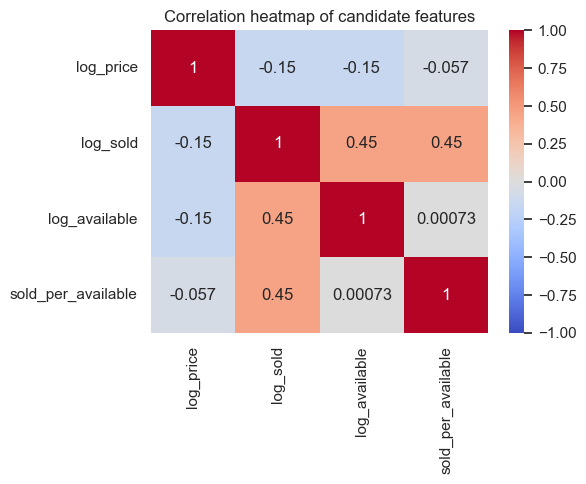

,log_price,log_sold,log_available,sold_per_available
log_price,1.000000,-0.148724,-0.154829,-0.057448
log_sold,-0.148724,1.000000,0.445409,0.450050
log_available,-0.154829,0.445409,1.000000,0.000733
sold_per_available,-0.057448,0.450050,0.000733,1.000000


In [23]:
# Correlation matrix for the candidate clustering features
features_for_corr = ["log_price", "log_sold", "log_available", "sold_per_available"]

corr_matrix = df_clean[features_for_corr].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation heatmap of candidate features")
plt.tight_layout()
plt.show()

corr_matrix


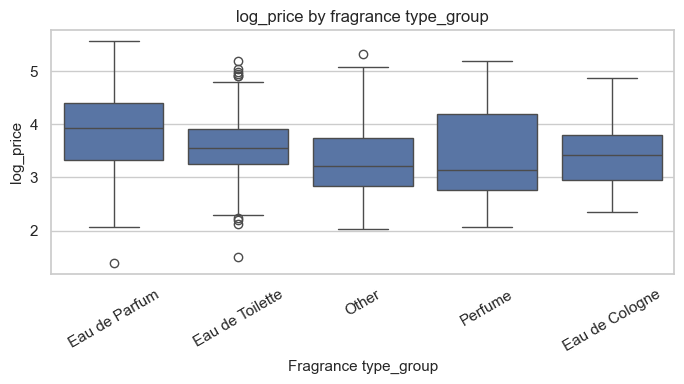

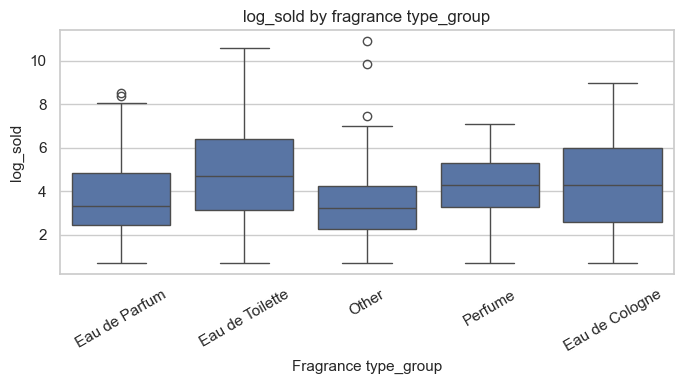

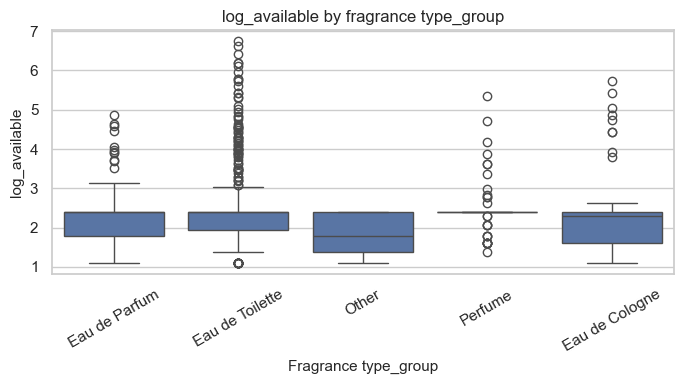

In [24]:
features_for_box = ["log_price", "log_sold", "log_available"]

for feat in features_for_box:
    plt.figure(figsize=(7, 4))
    sns.boxplot(data=df_clean, x="type_group", y=feat)
    plt.title(f"{feat} by fragrance type_group")
    plt.xlabel("Fragrance type_group")
    plt.ylabel(feat)
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


The correlation heatmap shows that the engineered features capture related but not redundant aspects of the listings:

- `log_price` is only weakly and negatively correlated with the other variables. This suggests that higher-priced perfumes do not automatically have higher stock levels or higher sales volume, so price provides a relatively independent axis for clustering.
- `log_sold` has a moderate positive correlation with both `log_available` and `sold_per_available` (around 0.45). Listings that sell more units tend to have more stock and, on average, achieve higher sales per unit of stock.
- `log_available` is only very weakly related to `sold_per_available`. This indicates that the ratio truly captures efficiency rather than just reflecting large or small inventories.

Importantly, none of the pairwise correlations are close to 1 in magnitude, so I do not see any obvious duplication where one feature could be removed without losing information. Instead, each feature adds a slightly different commercial perspective: pricing, scale of demand, stock intensity and sales efficiency.

The boxplots by `type_group` provide further context:

- `log_price` is generally higher for Eau de Parfum and Perfume, while Eau de Toilette and Eau de Cologne tend to sit at a slightly lower price range. This aligns with how these formats are positioned in the market.
- `log_sold` shows that Eau de Toilette listings often have higher median sales, suggesting that this format is more widely purchased, while other formats have more mixed sales patterns.
- `log_available` indicates that Eau de Toilette also tends to be stocked in larger quantities, whereas Perfume and “Other” categories often have smaller inventories.

These patterns confirm that the engineered features vary meaningfully across fragrance types and that the simplified `type_group` variable will be useful when I later interpret and label the clusters in business terms, even though it is not used directly as a numeric input to the clustering algorithms.


In [25]:
# Log-transform the sold_per_available ratio to reduce the impact of extreme values
df_clean["log_sold_per_available"] = np.log1p(df_clean["sold_per_available"])

# Final feature set for clustering (all on a log or ratio scale)
features_for_clustering = [
    "log_price",
    "log_sold",
    "log_available",
    "log_sold_per_available"
]

print("Final features for clustering:")
print(features_for_clustering)

# Quick check of distributions
df_clean[features_for_clustering].describe().T


Final features for clustering:
['log_price', 'log_sold', 'log_available', 'log_sold_per_available']


,count,mean,std,min,25%,50%,75%,max
log_price,990.0,3.627914,0.670125,1.386294,3.177637,3.603049,4.094303,5.561028
log_sold,990.0,4.283952,2.062323,0.693147,2.708050,3.891820,5.756525,10.897720
log_available,990.0,2.300874,0.851423,1.098612,1.791759,2.397895,2.397895,6.736967
log_sold_per_available,990.0,2.256225,1.585224,0.019803,1.023384,1.923136,3.124039,8.500010


Based on the distribution plots, the correlation heatmap and the differences across fragrance types, I make the following decisions for the clustering stage:

- I use **log-transformed versions** of price, sold units and available units to stabilise the variance and reduce the influence of extreme marketplace values.
- I replace the raw `sold_per_available` ratio with a log-transformed version, `log_sold_per_available`, so that listings with exceptionally high efficiency do not dominate the distance calculations.
- I retain all four engineered features (`log_price`, `log_sold`, `log_available`, `log_sold_per_available`) because they provide complementary information about price positioning, demand scale, inventory scale and sales efficiency.

The exploratory analysis shows that these features are not perfectly correlated, vary in a meaningful way across fragrance formats and remain commercially interpretable. I therefore consider them a suitable and well-justified input set for the clustering algorithms that I will apply in the next phase.


### Phase 4 – Clustering models

With a clean and well-understood feature set, I now move on to clustering. The aim of this phase is to compare several unsupervised algorithms and assess how well they group similar perfume listings together.

I focus on three clustering methods:

- **K-Means** – a widely used partitioning algorithm that assigns each listing to one of *k* clusters based on Euclidean distance.
- **Hierarchical clustering** – an agglomerative approach that builds a hierarchy of clusters, which I will visualise with a dendrogram to understand how clusters merge at different distance levels.
- **DBSCAN** – a density-based method that can detect dense regions of listings and mark isolated observations as noise, which is useful for identifying outliers in the marketplace.

Before fitting these models, I standardise the selected features so that each variable contributes equally to the distance calculations. I then explore different numbers of clusters for K-Means, inspect the hierarchical structure, and experiment with different epsilon values for DBSCAN. Throughout this phase I use internal validation metrics such as the Silhouette Score and the Davies–Bouldin Index, alongside visual inspection and business interpretability, to judge the quality of the clustering solutions.


In [26]:
from sklearn.preprocessing import StandardScaler

# Feature matrix for clustering
X = df_clean[features_for_clustering].values

# Standardise features to zero mean and unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Shape of X_scaled:", X_scaled.shape)
print("Means after scaling (approx.):", X_scaled.mean(axis=0))
print("Standard deviations after scaling (approx.):", X_scaled.std(axis=0))


Shape of X_scaled: (990, 4)
Means after scaling (approx.): [-2.76322175e-16  3.58859968e-16  5.74175948e-17 -3.44505569e-16]
Standard deviations after scaling (approx.): [1. 1. 1. 1.]


In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

k_values = range(2, 9)  # try between 2 and 8 clusters
results = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertia = kmeans.inertia_
    sil = silhouette_score(X_scaled, labels)
    dbi = davies_bouldin_score(X_scaled, labels)
    
    results.append({
        "k": k,
        "inertia": inertia,
        "silhouette": sil,
        "davies_bouldin": dbi
    })

kmeans_results = pd.DataFrame(results)
kmeans_results


,k,inertia,silhouette,davies_bouldin
0,2,2503.559639,0.356816,1.183646
1,3,1954.653307,0.372341,1.010890
2,4,1489.209239,0.318033,1.030245
3,5,1284.703336,0.299503,1.038929
4,6,1108.846905,0.294483,1.014006
5,7,1009.200535,0.268482,1.121340
6,8,928.492198,0.277521,1.045468


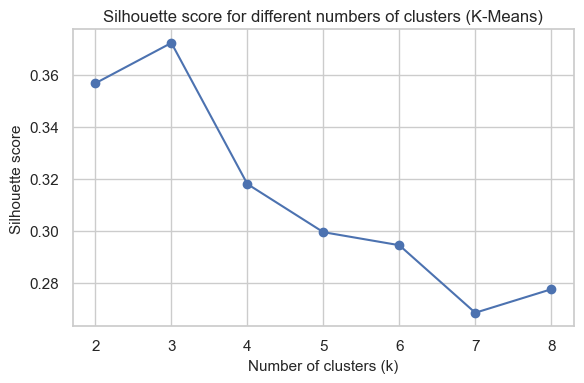

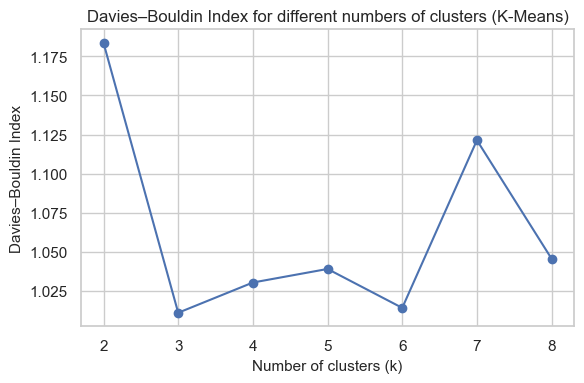

In [29]:
# Silhouette score vs k
plt.figure(figsize=(6, 4))
plt.plot(kmeans_results["k"], kmeans_results["silhouette"], marker="o")
plt.title("Silhouette score for different numbers of clusters (K-Means)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.xticks(kmeans_results["k"])
plt.tight_layout()
plt.show()

# Davies–Bouldin Index vs k
plt.figure(figsize=(6, 4))
plt.plot(kmeans_results["k"], kmeans_results["davies_bouldin"], marker="o")
plt.title("Davies–Bouldin Index for different numbers of clusters (K-Means)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Davies–Bouldin Index")
plt.xticks(kmeans_results["k"])
plt.tight_layout()
plt.show()


The K-Means results show a clear trade-off between the number of clusters and the quality metrics:

- The **Silhouette Score** peaks at around 0.37 when I use **3 clusters** and then gradually declines as I add more clusters. Although the absolute values are not very high, this is expected in a fragrance context where different perfumes can share many notes and commercial characteristics, so some overlap between clusters is inevitable.
- The **Davies–Bouldin Index (DBI)** is lowest (around **1.01**) for **3 clusters** and remains just above 1 for most other values of *k*. A DBI close to 1 suggests that the clusters are reasonably compact and separated, whereas values well above 1 would indicate poor separation.

From a business perspective, three segments are also attractive because they are easy to communicate: for example, I can later interpret them as a more affordable mass-market segment, a mid-range core segment and a higher-priced or more premium segment.

Taking all of this together, I select **k = 3** as the main K-Means solution to carry forward. In the next step I fit this model, attach the resulting cluster labels to the dataset and prepare to compare it against hierarchical clustering and DBSCAN using the same evaluation metrics.


In [30]:
# Fit the final K-Means model with k = 3
k_final = 3
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_scaled)

# Attach labels to the cleaned dataframe
df_clean["kmeans_cluster"] = kmeans_labels

# Evaluate the final model
sil_final = silhouette_score(X_scaled, kmeans_labels)
dbi_final = davies_bouldin_score(X_scaled, kmeans_labels)

print(f"Final K-Means model with k = {k_final}")
print(f"Silhouette Score: {sil_final:.3f}")
print(f"Davies–Bouldin Index: {dbi_final:.3f}")

# Basic overview of cluster sizes
print("\nCluster sizes:")
print(df_clean["kmeans_cluster"].value_counts().sort_index())


Final K-Means model with k = 3
Silhouette Score: 0.372
Davies–Bouldin Index: 1.011

Cluster sizes:
kmeans_cluster
0    306
1    600
2     84
Name: count, dtype: int64


The final K-Means model with **three clusters** achieves a Silhouette Score of about **0.37** and a Davies–Bouldin Index of roughly **1.01**. In the context of perfume data, where different listings often share overlapping scent notes and similar commercial characteristics, these values indicate a reasonably good balance between cluster cohesion and separation. I do not expect very high Silhouette values here because perfect separation between fragrance segments is unrealistic.

The cluster sizes are also acceptable from a business perspective:

- Cluster 0: 306 listings  
- Cluster 1: 600 listings  
- Cluster 2: 84 listings  

This mix suggests that I have two broad segments and one smaller but still meaningful niche segment, rather than a single dominant group plus a few tiny outlier clusters. As a result, the three-cluster K-Means solution provides a practical starting point for defining fragrance segments that marketing and product teams can work with.

In the next step I compare this baseline with hierarchical clustering and DBSCAN to see whether alternative algorithms offer better separation or reveal different structure in the same feature space.


#### Hierarchical clustering and dendrogram (Ward linkage)

To complement the K-Means baseline, I apply agglomerative hierarchical clustering with Ward linkage. This method starts with each listing as its own cluster and repeatedly merges the closest clusters. The resulting tree structure can be visualised with a dendrogram.

A full dendrogram for almost one thousand listings would be too dense to interpret, so I use a random subset of the data for the tree visual. The aim is to see at what distance levels clusters merge and whether a split into roughly three groups is supported by the hierarchical structure. I then fit an agglomerative model with three clusters on the full dataset and compare its evaluation metrics with the K-Means results.


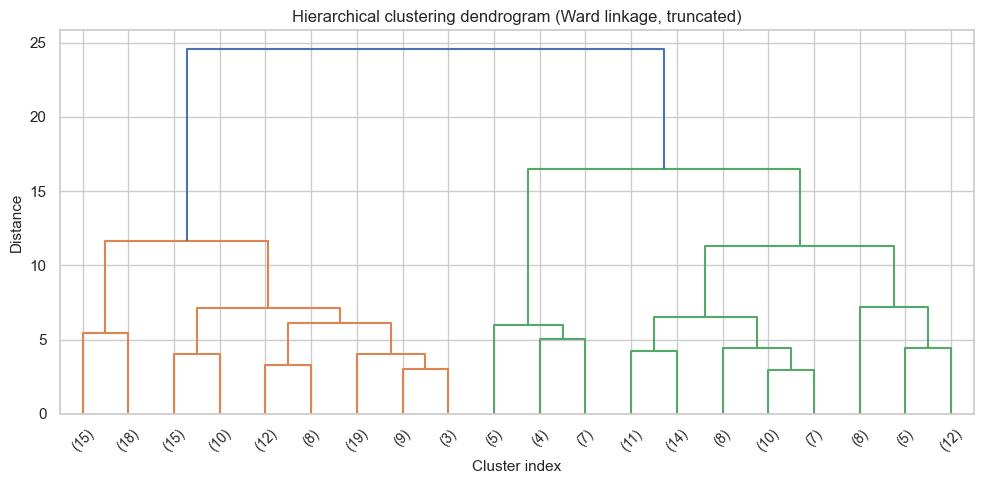

In [31]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Sample a subset of points for the dendrogram to keep the plot readable
np.random.seed(42)
subset_size = 200
subset_indices = np.random.choice(df_clean.index, size=subset_size, replace=False)
X_subset = X_scaled[df_clean.index.get_indexer(subset_indices)]

# Compute hierarchical clustering using Ward linkage
Z_ward = linkage(X_subset, method="ward")

plt.figure(figsize=(10, 5))
dendrogram(
    Z_ward,
    truncate_mode="lastp",  # show only the last merged clusters
    p=20,                   # number of leaf clusters to show
    leaf_rotation=45.,
    leaf_font_size=10.
)
plt.title("Hierarchical clustering dendrogram (Ward linkage, truncated)")
plt.xlabel("Cluster index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


In [32]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Fit Agglomerative (Ward linkage) with 3 clusters
agg_model = AgglomerativeClustering(n_clusters=3, linkage="ward")
agg_labels = agg_model.fit_predict(X_scaled)

# Attach labels
df_clean["agg_cluster"] = agg_labels

# Evaluation metrics
sil_agg = silhouette_score(X_scaled, agg_labels)
dbi_agg = davies_bouldin_score(X_scaled, agg_labels)

print("Agglomerative clustering (Ward linkage, 3 clusters)")
print(f"Silhouette Score: {sil_agg:.3f}")
print(f"Davies–Bouldin Index: {dbi_agg:.3f}")

print("\nCluster sizes:")
print(df_clean["agg_cluster"].value_counts().sort_index())


Agglomerative clustering (Ward linkage, 3 clusters)
Silhouette Score: 0.259
Davies–Bouldin Index: 1.214

Cluster sizes:
agg_cluster
0    502
1    408
2     80
Name: count, dtype: int64


The truncated dendrogram for Ward linkage shows that the listings can be grouped into a few broad branches before everything merges into a single cluster at higher distances. Visually, a split into roughly two to three main groups looks reasonable, which is consistent with the three-cluster K-Means solution.

When I fit an agglomerative model with **three clusters** using Ward linkage on the full dataset, I obtain:

- Silhouette Score ≈ **0.26**  
- Davies–Bouldin Index ≈ **1.21**

Compared with the K-Means model (Silhouette ≈ **0.37**, DBI ≈ **1.01**), hierarchical clustering performs noticeably worse on both cohesion and separation:

- The lower Silhouette Score indicates that points are less tightly grouped within their assigned clusters and more mixed with neighbouring clusters.
- The higher DBI suggests that the within-cluster spread is relatively large compared with the distance between cluster centres.

Cluster sizes for the hierarchical solution (502, 408, 80) are reasonably balanced, but the quality metrics and the lack of clear additional structure in the dendrogram imply that it does not offer a compelling improvement over K-Means. At this stage I therefore keep the **three-cluster K-Means model as the stronger candidate**, while still considering the hierarchical results as a useful cross-check on the broad structure of the data.


To complete the model comparison, I apply the DBSCAN algorithm. Unlike K-Means and hierarchical clustering, DBSCAN does not require me to specify the number of clusters in advance. Instead, it groups together dense regions of points and labels sparse points as noise.

Two key parameters control DBSCAN:

- **`eps`** – the maximum distance between two points for them to be considered neighbours.
- **`min_samples`** – the minimum number of neighbours required to form a dense region.

I keep `min_samples` fixed and vary `eps` across a range of values. For each setting I record:

- How many clusters DBSCAN detects (excluding noise),
- What proportion of points is labelled as noise,
- The Silhouette Score and Davies–Bouldin Index for the non-noise points, when there are at least two clusters.

This helps me understand how sensitive DBSCAN is to the choice of `eps` and whether it can find meaningful fragrance segments in this feature space.


In [33]:
from sklearn.cluster import DBSCAN

eps_values = [0.5, 0.7, 0.9, 1.1, 1.3]
min_samples = 10

dbscan_results = []

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X_scaled)
    
    # DBSCAN labels: -1 = noise
    n_noise = (labels == -1).sum()
    n_points = len(labels)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_ratio = n_noise / n_points
    
    sil = None
    dbi = None
    
    # Compute metrics only if there are at least 2 clusters and some non-noise points
    if n_clusters >= 2 and n_points - n_noise > n_clusters:
        mask = labels != -1
        sil = silhouette_score(X_scaled[mask], labels[mask])
        dbi = davies_bouldin_score(X_scaled[mask], labels[mask])
    
    dbscan_results.append({
        "eps": eps,
        "min_samples": min_samples,
        "n_clusters": n_clusters,
        "noise_ratio": noise_ratio,
        "silhouette": sil,
        "davies_bouldin": dbi
    })

dbscan_results_df = pd.DataFrame(dbscan_results)
dbscan_results_df


,eps,min_samples,n_clusters,noise_ratio,silhouette,davies_bouldin
0,0.5,10,3,0.197980,0.052757,0.892254
1,0.7,10,2,0.084848,0.329001,0.813261
2,0.9,10,1,0.042424,NaN,NaN
3,1.1,10,1,0.012121,NaN,NaN
4,1.3,10,1,0.005051,NaN,NaN


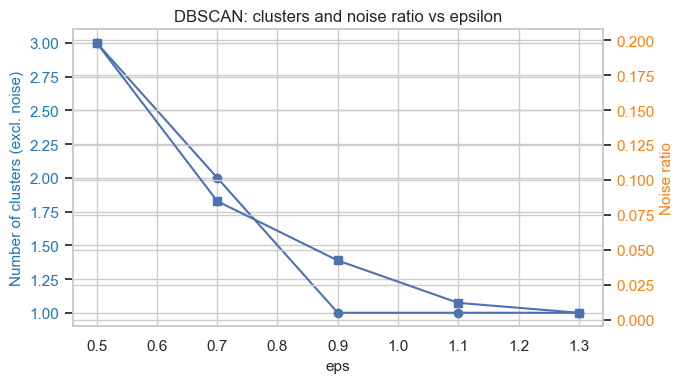

,eps,min_samples,n_clusters,noise_ratio,silhouette,davies_bouldin
0,0.5,10,3,0.197980,0.052757,0.892254
1,0.7,10,2,0.084848,0.329001,0.813261
2,0.9,10,1,0.042424,NaN,NaN
3,1.1,10,1,0.012121,NaN,NaN
4,1.3,10,1,0.005051,NaN,NaN


In [34]:
# Plot number of clusters and noise ratio vs epsilon
fig, ax1 = plt.subplots(figsize=(7, 4))

color = "tab:blue"
ax1.set_xlabel("eps")
ax1.set_ylabel("Number of clusters (excl. noise)", color=color)
ax1.plot(dbscan_results_df["eps"], dbscan_results_df["n_clusters"], marker="o")
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()
color = "tab:orange"
ax2.set_ylabel("Noise ratio", color=color)
ax2.plot(dbscan_results_df["eps"], dbscan_results_df["noise_ratio"], marker="s")
ax2.tick_params(axis="y", labelcolor=color)

plt.title("DBSCAN: clusters and noise ratio vs epsilon")
fig.tight_layout()
plt.show()

dbscan_results_df


The DBSCAN results show how sensitive the algorithm is to the choice of `eps`:

- At **eps = 0.5**, DBSCAN finds **3 clusters** with almost **20% of points marked as noise**. The Silhouette Score is very low (around **0.05**), even though the Davies–Bouldin Index is below 1. This suggests that the clusters are not well separated and many points lie close to the boundaries between groups.
- At **eps = 0.7**, DBSCAN collapses to **2 clusters** with a lower noise ratio (around **8%**) and a Silhouette Score of roughly **0.33**. The DBI falls to about **0.81**, which is a good value in practical terms. However, the model now offers only a simple two-way split of the marketplace rather than a richer segmentation.
- For **eps ≥ 0.9**, DBSCAN effectively treats the data as one large cluster with almost no noise. In these cases the internal validation metrics are not defined because there is no meaningful clustering structure.

From a business perspective, these outcomes are not ideal. With small `eps`, too many listings are classified as noise and the separation between clusters is weak. With larger `eps`, DBSCAN either returns only two broad clusters or degenerates into a single cluster. The algorithm therefore does not uncover a stable and interpretable structure that would support a multi-segment fragrance strategy.


To understand how the three K-Means clusters relate to each other, I project the four standardised features into two dimensions using Principal Component Analysis (PCA). PCA creates new axes (principal components) that capture as much of the variance in the data as possible. I then plot the listings in this reduced space and colour them by their K-Means cluster.

This type of plot does not show the full four-dimensional structure, but it provides an intuitive picture of how well the clusters are separated, where they overlap and whether there are any obvious outliers. It is also a useful visual for explaining the segmentation to non-technical stakeholders.


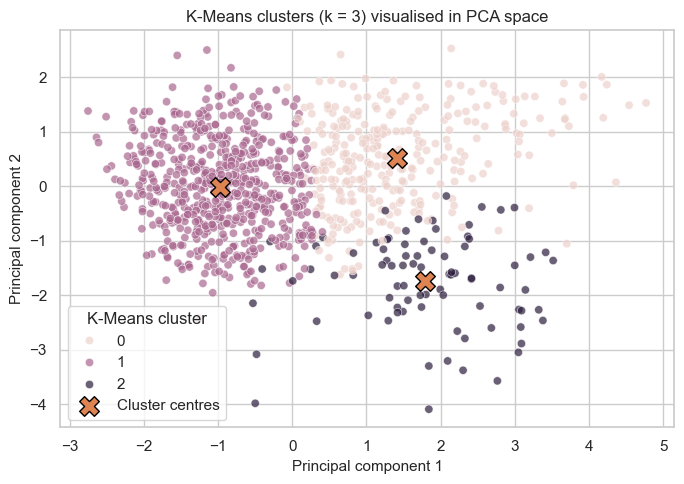

In [35]:
from sklearn.decomposition import PCA

# Fit PCA on the scaled features and project to 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df_clean["pca1"] = X_pca[:, 0]
df_clean["pca2"] = X_pca[:, 1]

# Transform K-Means centroids into the same PCA space
centroids_pca = pca.transform(kmeans_final.cluster_centers_)

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=df_clean,
    x="pca1",
    y="pca2",
    hue="kmeans_cluster",
    alpha=0.7
)
plt.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    marker="X",
    s=200,
    edgecolor="black",
    linewidth=1,
    label="Cluster centres"
)
plt.title("K-Means clusters (k = 3) visualised in PCA space")
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
plt.legend(title="K-Means cluster")
plt.tight_layout()
plt.show()


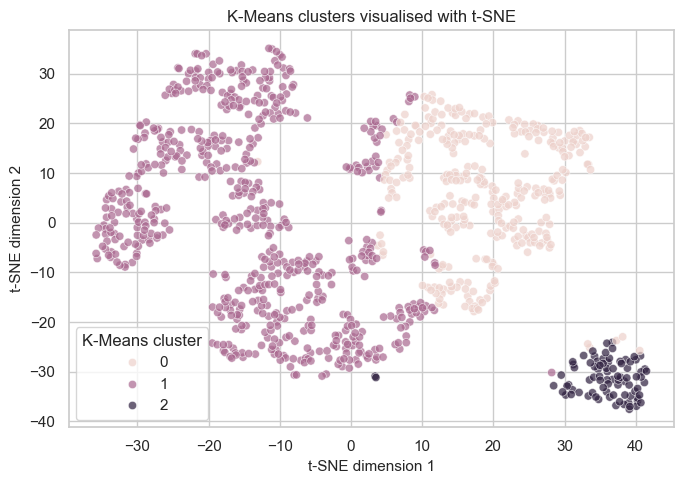

In [37]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1000,  # ← Changed from n_iter to max_iter
    random_state=42
)
X_tsne = tsne.fit_transform(X_scaled)

df_clean["tsne1"] = X_tsne[:, 0]
df_clean["tsne2"] = X_tsne[:, 1]

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=df_clean,
    x="tsne1",
    y="tsne2",
    hue="kmeans_cluster",
    alpha=0.7
)
plt.title("K-Means clusters visualised with t-SNE")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.legend(title="K-Means cluster")
plt.tight_layout()
plt.show()

The PCA plot projects the four standardised features into two principal components and colours the points by their K-Means cluster. In this view I can see that:

- One cluster sits mainly on the **right-hand side** of the plot with relatively higher values on the first principal component. This suggests a segment with a distinct commercial profile, for example higher sales or a different price–stock balance.
- A second cluster occupies the **left-hand side** of the plot, forming a dense cloud of listings that are relatively similar to each other.
- The third cluster is located more **towards the lower-right area**, indicating a smaller group of listings that differ from the others mainly along the second principal component.

There is some overlap between the clouds, which matches the earlier observation that perfumes can share notes and commercial characteristics. The Silhouette Score of around 0.37 already indicated that the clusters are not perfectly separated, and this visual confirms that the segments are distinct but not completely isolated.

The t-SNE plot provides an alternative nonlinear view of the same K-Means labels. Here the three clusters form more clearly separated islands, which supports the idea that the three segments capture real structure in the data rather than being purely an artefact of the PCA projection. I treat the PCA plot as the main visual for communication, because it is easier to explain to non-technical stakeholders, and I use the t-SNE plot as a supporting check that the segmentation is reasonably stable in a different two-dimensional representation.


Across the three algorithms I observe the following:

- **K-Means (3 clusters)**  
  - Silhouette Score ≈ **0.37**  
  - Davies–Bouldin Index ≈ **1.01**  
  - Three well-populated clusters (306, 600 and 84 listings) that are straightforward to explain to business stakeholders.
- **Hierarchical clustering (Ward linkage, 3 clusters)**  
  - Silhouette Score ≈ **0.26**  
  - Davies–Bouldin Index ≈ **1.21**  
  - Balanced cluster sizes but noticeably weaker separation and cohesion than K-Means, with no clear structural advantage in the dendrogram.
- **DBSCAN**  
  - At eps = 0.5: three clusters but a very low Silhouette Score (≈ **0.05**) and almost 20% noise.  
  - At eps = 0.7: two clusters, Silhouette ≈ **0.33**, DBI ≈ **0.81**, but the segmentation is very coarse and still leaves a noticeable amount of noise.  
  - For larger eps values, DBSCAN collapses into a single cluster with no useful segmentation.

In terms of the three criteria highlighted in class—**separation, cohesion and interpretability**—the **three-cluster K-Means model** provides the best compromise:

- It offers the highest Silhouette Score among the multi-cluster solutions, indicating relatively good separation for this type of overlapping fragrance data.
- Its Davies–Bouldin Index is close to 1, signalling acceptable cohesion even if the clusters are not perfectly compact.
- Most importantly, three clusters form a manageable set of segments that I can name and describe in commercial language (for example, accessible everyday fragrances, core mid-range fragrances and more premium or high-intensity offerings).

For these reasons I select the **three-cluster K-Means model** as the final clustering solution for the rest of the analysis. The hierarchical and DBSCAN results remain useful as sensitivity checks, but they do not outperform K-Means on either internal metrics or business interpretability.


Overall, the three-cluster K-Means model appears robust for this dataset. I have tested alternative cluster counts, compared K-Means with hierarchical clustering and DBSCAN, and checked the results using internal validation metrics and low-dimensional visualisations. All of these checks point to a consistent three-segment structure.

At the same time, there are a few limitations to keep in mind:

- The Silhouette Scores are moderate rather than high, which reflects the fact that perfume listings naturally overlap in terms of notes and commercial behaviour.
- The evaluation is based on internal metrics only; I do not have external labels such as explicit customer segments to validate the clusters against.
- The feature set focuses on commercial variables (price, stock and sales). Additional information such as detailed scent notes or customer ratings could refine the segments further, but this is outside the scope of the current coursework.

Given these considerations, I treat the three-cluster K-Means solution as a reasonable and defensible segmentation for this assignment and I now focus on interpreting what each cluster means for the business.


### Phase 5 – Cluster profiling and business interpretation

With the final K-Means model selected, I now focus on understanding what each cluster represents in practical business terms.

In this phase I:

- Summarise the average values of the key commercial features (`price`, `sold`, `available` and their log-transformed versions) for each cluster.
- Examine how clusters differ by fragrance format (`type_group`) and by brand mix.
- Assign descriptive names to the clusters that reflect their typical price level, sales intensity and stock profile.
- Prepare tables and commentary that explain the clusters clearly for a non-technical audience.

The goal is to move from abstract cluster labels (0, 1 and 2) to meaningful fragrance segments that ScentTech Analytics can use for marketing, assortment planning and recommendation strategies.


In [38]:
# Numeric summary (using original and log features) by K-Means cluster
numeric_cols_for_profile = [
    "price", "sold", "available",
    "log_price", "log_sold", "log_available", "log_sold_per_available"
]

cluster_numeric_profile = (
    df_clean
    .groupby("kmeans_cluster")[numeric_cols_for_profile]
    .mean()
    .round(2)
)

cluster_sizes = df_clean["kmeans_cluster"].value_counts().sort_index()

print("Cluster sizes:")
print(cluster_sizes)
cluster_numeric_profile


Cluster sizes:
kmeans_cluster
0    306
1    600
2     84
Name: count, dtype: int64


,price,sold,available,log_price,log_sold,log_available,log_sold_per_available
kmeans_cluster,,,,,,,
0,39.99,1955.92,9.05,3.50,6.32,2.24,4.10
1,51.73,28.55,7.42,3.74,2.92,2.02,1.31
2,29.11,1618.82,138.36,3.29,6.61,4.55,2.30


In [39]:
# Distribution of fragrance type_group in each cluster (percentages)
type_distribution = (
    df_clean
    .groupby(["kmeans_cluster", "type_group"])
    .size()
    .groupby(level=0)
    .apply(lambda x: 100 * x / x.sum())
    .round(1)
    .unstack(fill_value=0)
)

# Top 5 brands per cluster by count
top_brands_per_cluster = (
    df_clean
    .groupby("kmeans_cluster")["brand"]
    .value_counts()
    .groupby(level=0)
    .head(5)
)

type_distribution, top_brands_per_cluster


(type_group                     Eau de Cologne  Eau de Parfum  Eau de Toilette  \
 kmeans_cluster kmeans_cluster                                                   
 0              0                          7.5           24.8             56.5   
 1              1                          6.0           40.3             37.2   
 2              2                         10.7           11.9             69.0   
 
 type_group                     Other  Perfume  
 kmeans_cluster kmeans_cluster                  
 0              0                 5.6      5.6  
 1              1                10.3      6.2  
 2              2                 0.0      8.3  ,
 kmeans_cluster  brand         
 0               Giorgio Armani    23
                 Armaf             15
                 Ralph Lauren      11
                 Calvin Klein      10
                 Versace           10
 1               Giorgio Armani    36
                 Paco Rabanne      34
                 Unbranded         30
      

The cluster summaries reveal three distinct commercial patterns:

- **Cluster 0**  
  - Medium average price and relatively low stock levels.  
  - Very high average units sold and the highest value of `log_sold_per_available`.  
  - A strong presence of Eau de Toilette and Eau de Parfum, with well-known brands such as Giorgio Armani, Armaf, Ralph Lauren, Calvin Klein and Versace.  
  This looks like a group of **popular, mid-priced fragrances that convert stock into sales efficiently**.

- **Cluster 1**  
  - The **highest average price** across all clusters, but very low average units sold.  
  - Slightly lower stock levels than Cluster 2 and the lowest `log_sold_per_available`, indicating slow turnover.  
  - A higher share of Eau de Parfum and a strong representation of premium brands such as Giorgio Armani, Paco Rabanne, Ralph Lauren and Dolce&Gabbana, plus some unbranded listings.  
  This cluster behaves like a **premium or niche segment where products are positioned at higher prices but move slowly**.

- **Cluster 2**  
  - The **lowest average price**, combined with very high units sold and **very large average stock levels**.  
  - `log_sold_per_available` is lower than in Cluster 0 but higher than in Cluster 1, so these listings sell well in absolute terms but not as efficiently as the best performers.  
  - A strong dominance of Eau de Toilette and a mix of less prominent brands such as Armaf, Liz Claiborne, Azzaro and Jaguar.  
  This group resembles a **value-oriented, high-stock segment where fragrances are priced aggressively and sold in volume**.

These patterns suggest a natural interpretation of the three clusters as: efficient mid-priced bestsellers, premium slow movers and value high-stock workhorses. I use these ideas to assign more descriptive names in the next step.


In [44]:
# Recompute type share per cluster in a way that always gives a Series for each cluster
type_counts = df_clean.groupby(["kmeans_cluster", "type_group"]).size()

type_share_by_cluster = (
    type_counts
    .groupby(level=0)
    .apply(lambda s: 100 * s / s.sum())
    .round(1)
)

# Nice table version (rows = clusters, columns = type groups)
type_distribution = type_share_by_cluster.unstack(fill_value=0)

# Top 5 brands per cluster by count
brand_counts = df_clean.groupby("kmeans_cluster")["brand"].value_counts()
top_brands_per_cluster = brand_counts.groupby(level=0).head(5)

type_distribution, top_brands_per_cluster


(type_group                     Eau de Cologne  Eau de Parfum  Eau de Toilette  \
 kmeans_cluster kmeans_cluster                                                   
 0              0                          7.5           24.8             56.5   
 1              1                          6.0           40.3             37.2   
 2              2                         10.7           11.9             69.0   
 
 type_group                     Other  Perfume  
 kmeans_cluster kmeans_cluster                  
 0              0                 5.6      5.6  
 1              1                10.3      6.2  
 2              2                 0.0      8.3  ,
 kmeans_cluster  brand         
 0               Giorgio Armani    23
                 Armaf             15
                 Ralph Lauren      11
                 Calvin Klein      10
                 Versace           10
 1               Giorgio Armani    36
                 Paco Rabanne      34
                 Unbranded         30
      

In [46]:
# Give business-friendly names to the clusters
cluster_names = {
    0: "High-intensity mid-priced bestsellers",
    1: "Premium niche slow movers",
    2: "Value high-stock workhorses"
}

df_clean["cluster_name"] = df_clean["kmeans_cluster"].map(cluster_names)

summary_rows = []

for cid, name in cluster_names.items():
    row = {}
    row["Cluster"] = f"{cid} – {name}"
    row["Size (listings)"] = int(cluster_sizes[cid])
    row["Mean price"] = round(cluster_numeric_profile.loc[cid, "price"], 2)
    row["Mean sold units"] = round(cluster_numeric_profile.loc[cid, "sold"], 1)
    row["Mean available units"] = round(cluster_numeric_profile.loc[cid, "available"], 1)
    
    # Dominant fragrance types (top 2 by share)
    type_share = type_share_by_cluster.loc[cid]          # <-- always a Series now
    top_types = type_share.sort_values(ascending=False).head(2).index.tolist()
    # Extract type names from tuples (index is (cluster_id, type_name))
    top_type_names = [t[1] for t in top_types]  # Get second element of each tuple
    row["Dominant fragrance types"] = ", ".join(top_type_names)
    
    # Top 3 brands by frequency
    brand_series = top_brands_per_cluster.loc[cid]       # Series indexed by brand
    top_brands = brand_series.head(3).index.tolist()
    row["Top brands (by count)"] = ", ".join(top_brands)
    
    summary_rows.append(row)

cluster_summary_table = pd.DataFrame(summary_rows)
cluster_summary_table

,Cluster,Size (listings),Mean price,Mean sold units,Mean available units,Dominant fragrance types,Top brands (by count)
0,0 – High-intensity mid-priced bestsellers,306,39.99,1955.9,9.0,"Eau de Toilette, Eau de Parfum","Giorgio Armani, Armaf, Ralph Lauren"
1,1 – Premium niche slow movers,600,51.73,28.6,7.4,"Eau de Parfum, Eau de Toilette","Giorgio Armani, Paco Rabanne, Unbranded"
2,2 – Value high-stock workhorses,84,29.11,1618.8,138.4,"Eau de Toilette, Eau de Parfum","Armaf, Liz Claiborne, Ralph Lauren"


## Phase 6 – Visual summary of the fragrance segments

In this phase I create a small set of clear visualisations that summarise the three segments identified by the K-Means model. The aim is to provide simple, management-friendly charts that highlight how the clusters differ in terms of price, sales volume, stock levels and fragrance formats.

I focus on:

- Comparing the mean price and mean units sold across clusters.
- Showing how the mix of fragrance formats (Eau de Toilette, Eau de Parfum and others) changes from one cluster to another.
- Reinforcing the interpretation of the clusters as mid-priced bestsellers, premium slow movers and value high-stock workhorses.


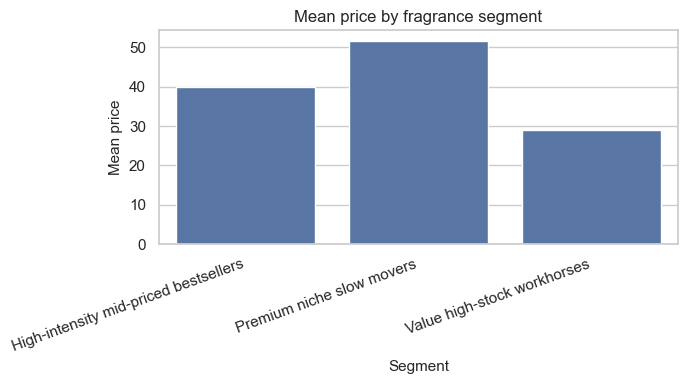

In [48]:
# Explicitly build a small DataFrame for plotting mean price by segment
cluster_plot_order = [0, 1, 2]

price_plot = pd.DataFrame({
    "Cluster": [cluster_names[cid] for cid in cluster_plot_order],
    "Mean price": [cluster_numeric_profile.loc[cid, "price"] for cid in cluster_plot_order]
})

plt.figure(figsize=(7, 4))
sns.barplot(data=price_plot, x="Cluster", y="Mean price")
plt.title("Mean price by fragrance segment")
plt.xlabel("Segment")
plt.ylabel("Mean price")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()


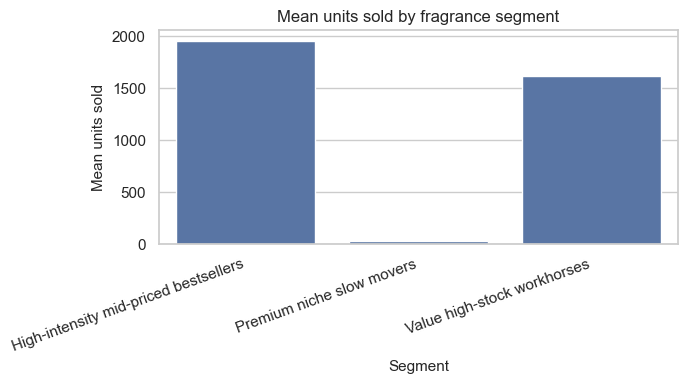

In [49]:
sold_plot = pd.DataFrame({
    "Cluster": [cluster_names[cid] for cid in cluster_plot_order],
    "Mean sold units": [cluster_numeric_profile.loc[cid, "sold"] for cid in cluster_plot_order]
})

plt.figure(figsize=(7, 4))
sns.barplot(data=sold_plot, x="Cluster", y="Mean sold units")
plt.title("Mean units sold by fragrance segment")
plt.xlabel("Segment")
plt.ylabel("Mean units sold")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()


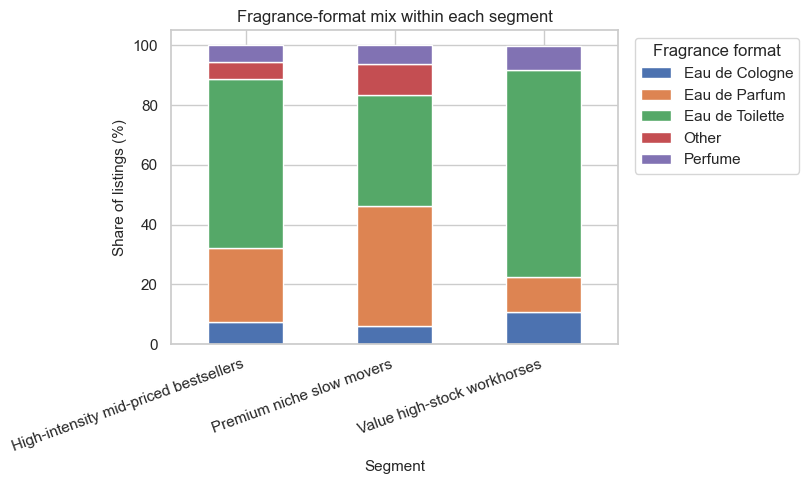

In [51]:
# Prepare type distribution for plotting with clean segment names
cluster_plot_order = [0, 1, 2]

type_dist_plot = type_distribution.loc[cluster_plot_order].copy()
type_dist_plot.index = [cluster_names[cid] for cid in cluster_plot_order]

type_dist_plot.plot(kind="bar", stacked=True, figsize=(8, 5))
plt.title("Fragrance-format mix within each segment")
plt.xlabel("Segment")
plt.ylabel("Share of listings (%)")
plt.xticks(rotation=20, ha="right")
plt.legend(title="Fragrance format", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


These charts give me a clear, business-focused picture of how the three fragrance segments differ:

- **Price positioning**  
  The mean price chart confirms that the **premium niche slow movers** segment is positioned at the highest price point, while the **value high-stock workhorses** are clearly the most affordable. The **high-intensity mid-priced bestsellers** sit in the middle, which is consistent with a mainstream but not budget positioning.

- **Demand and volume**  
  The mean units sold chart shows that the **high-intensity mid-priced bestsellers** and the **value high-stock workhorses** are the main volume drivers. The mid-priced bestsellers achieve very high sales with relatively modest stock levels, while the value segment sells large volumes backed by high inventory. In contrast, the premium niche segment sells very few units despite higher prices, underlining its role as a prestige rather than a volume segment.

- **Fragrance-format mix**  
  The stacked bar chart highlights that Eau de Toilette dominates the **value high-stock workhorses** segment, reflecting its mass-market orientation. The **premium niche slow movers** have a much higher share of Eau de Parfum, which fits a more intense and premium positioning. The **high-intensity mid-priced bestsellers** combine both formats, which helps explain why they appeal to a broad customer base.

Overall, these visuals support the interpretation that the three segments play different roles in the portfolio: mid-priced bestsellers drive everyday revenue, premium niche products support brand image at higher price points, and value workhorses sustain high-volume, price-sensitive demand. This makes the segmentation easy to explain to management and provides a concrete basis for targeted pricing, inventory and marketing decisions.
